In [2]:
import numpy as np
from __future__ import division
import scipy as sc
from scipy.interpolate import interp1d
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import os
import sys
import csv
import mne
import sklearn
from sklearn.cluster import KMeans


# Data preprocessing


## ECG/EDA


In [33]:
##########################################
#   Base line removal
#########################################

def detrendSpline(signal,fs,l_w = 1):
    """ input signal: ECG signal to be detrended
              fs: sampliing frequency
              l_w: window length in secs (1 sec by default)
        output ecg_detrend: ecg without the base line
               s_pp: trend
    """
    L_s = len(signal)
    t = np.arange(0,L_s)*1./fs
    
    numSeg = np.floor(t[-1]/l_w)

    s_m = np.zeros(int(numSeg))
    t_m = np.zeros(int(numSeg))
    
    for k in range(int(numSeg)):
        #for over each window and compute the median
        ind_seg = (t >= (k)*l_w) & (t <= (k+1)*l_w)
        t_aux = t[ind_seg]
        t_m[k] = t_aux[int(len(t_aux)/2)]
        s_m[k] = np.median(signal[ind_seg]);
   
    #fit the spline to the median points
    #Add first and last value in
    t_m = np.concatenate(([0],t_m,[t[-1]]))
    s_m = np.concatenate(([signal[0]],s_m,[signal[-1]]))
    cp = interp1d(t_m,s_m,kind = 'cubic')
    trend = cp(t)
    ecg_detrend = signal - trend;
    plt
    return ecg_detrend,trend

###############################################################################

###############################################################################
# Band pass filtering
###############################################################################

def bandpass_qrs_filter(ecg, fs, fc1 = 5,fc2 = 15):
    """input fc1: cut frequency 1 in Hz
             fc2: cut frequency 2 in Hz
             fs: sampling frequency in Hz
    
        output ecg_filt: filtered ecg
    """
    fn = fs/2. #Nyquist frequency
    N = 128 #filter order
    
    b = signal.firwin(N, [fc1/fn, fc2/fn], pass_zero = False)
    
    #zero phase filter
    
    ecg_filtered = signal.filtfilt(b,np.arange(1,2),ecg)
    return ecg_filtered

###############################################################################
# Exponential threshold beat detection
###############################################################################
def exp_beat_detection(ecg,fs,Tr = .180,a = .7,b = 0.999):
    """ input ecg: ecg to be detected
              Tr: refractory period in seconds. Default 180 ms
              a: correction fraction of the threshold with respecto to the
              maximun of the R peak. Default 0.7
              b: exponential decay. Default 0.999
              
        output beat: beat detected
               th: threshold function
               qrs_index: qrs index  
    """
    Tr = np.floor(Tr*fs)
    end = len(ecg) #end point
    maximum_value = np.max(ecg/3.)
    
    beat = np.zeros((end,1))
    qrs_index = []
    th = []
    
    th.append(a*np.max(ecg)) # threshold initialization 
    
    detect = Tr*(-1) + 1 #variable that controls the refractory period
    
    for k in range(1,end):
        #for over all the points in the ECG

        if (ecg[k] > th[k-1]) & (k > (detect + Tr)):
            detect = k #new refractory period
            qrs_index.append(k)
            beat[k] = maximum_value
            
        #if no detection, update the threshold
        update_th = np.max((a*ecg[k],b*th[k-1]))
        th.append(update_th)
        
    return beat, th, qrs_index

###############################################################################
# R-peak detection
###############################################################################    

def r_peak_detection(ecg_filtered,ecg_original,fs,beat,th,qrs_index,Tr = .100):
    """ r-peak detection in the original ecg. Once, the QRS is detected in the
    filtered ecg, this functions allows to estimate de position of the r-peak
    
    inputs ecg_filtered: ecg filtered on which the qrs detection is performed.
           ecg_original: original ecg
           fs: sampling frequency.
           beat: qrs detections
           th: threshold function that allowed the detection of qrs complexes
           qrs_index: indices of the qrs in the filtered ecg.
           
    outputs
            r_peaks: position of the r_peaks on the original ecg
            rr: RR-interval time series
    """    
    Tr_s = np.round(Tr * fs)
    r_peaks = np.zeros(len(ecg_filtered))

    for idx in qrs_index:
        
        #build an r-peak search window around the qrs_complex detected
        window = range(idx-3,idx + int(Tr_s/2))
        
        if (window[0] > 0) & (window[-1] < len(ecg_filtered)):
            beat_original = ecg_original[window]
            idx_rpeak = np.argmax(beat_original)
            
            r_peaks[idx - 3 + idx_rpeak] = 1
    #end of for        
    r_peak = np.nonzero(r_peaks)[0]
    rr = (np.diff(r_peak)/fs)*1000.
    return r_peak, rr

In [34]:
 def perct_filter(rr, prct):
        """
        Artifact detection function using information from previous interval. It processes the RR 
        interval time series in a beat-wise fashion. Te actual RR interval is identified as
        non-sinusal  if the following equation holds:
            RR(n) > prct * RR(n-1) then RR(n) is non-sinusal
        
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        prct : float
            Percentage used in the equation.
        Returns
        -------
        ind_not_N : boolean numpy array (n_samples,1)
            Boolean array with True in locations where the corresponding RR interval
            is non-sinusal (not Normal).
        """

        ind_not_N = [False]*len(rr)
        ind_not_N = np.array(ind_not_N) #convert to a numpy array
        #Construct a matrix with the percentage * RR(n-1)

        percMatrix = np.abs(np.diff(rr) / rr[:-1])
        
        pos_ind_not_N = np.where(percMatrix > prct)[0]
        
        if len(pos_ind_not_N) > 0:
            ind_not_N[pos_ind_not_N+1] = True  #consider the first rr-interval as normal.      
        
        return ind_not_N
    
def threshold_filter(rr):
        """
        Artifact detection function using threshold method. It processes the RR 
        interval time series in a beat-wise fashion. An interval is identifiead as
        non-sinusal if RR(n) > thr_up or RR(n) < thr_low
        where: thr_up = 2000 (ms); thr_low = 300 (ms).
        
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        Returns
        -------
        ind_not_N : boolean numpy array (n_samples,1)
            Boolean array with True in locations where the corresponding RR interval
            is non-sinusal (not Normal).
        """
        ind_not_N = [False]*len(rr)
        ind_not_N = np.array(ind_not_N) #convert to a numpy array
        
        pos_ind_not_N = np.concatenate((np.where(rr > 2000)[0],np.where(rr<300)[0]))
        
        if len(pos_ind_not_N) > 0:
            ind_not_N[pos_ind_not_N] = True
            
        return ind_not_N
    
def artifact_ectopic_correction( rr, ind_not_N, method):
    
        """
        Function that corrects artifact-ectopic beats by interpolation. 
        
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        ind_not_N_beats: boolean numpy array (n_samples,1)
            Boolean array with True in locations where the corresponding RR interval
            is non-sinusal (not Normal).
        method : "cubic", "linear","nearest","zero","slinear", "quadratic","cubic", default = "cubic"
            Kind of interpolation, by default spline interpolation of third order. For more details
            see 
        Returns
        -------
        rr_correcte : numpy array (n_samples,1)
            RR interval time serie with interpolated RR intervals in places 
            detected as non-sinusal.
    
        See also
        --------
        
        scipy.interpolate.interp1d
        
        """
        
                
        
        t_rr = np.cumsum(rr)

        rr_aux = rr[np.logical_not(ind_not_N)]

        t_rr_aux = t_rr[np.logical_not(ind_not_N)]        
        
        #TO_DO verify extrapolation with splines in scipy
        #Meanwhile: extrapolate using the mean value of the 5 first, 
        f = interp1d(t_rr_aux,rr_aux,method,fill_value = (np.mean(rr_aux[:5]),np.mean(rr_aux[-5:])),bounds_error = False)
        
        rr_corrected = f(t_rr)
        
        return rr_corrected
    
def is_valid(ind_not_N,perct_valid = 0.2):
        """
        Function that checks the validity of a RR-interval time seris to be used
        in the HRV analysis. Usually if there are more than 20% of non-sinusals
        beats the segment is discarded for the posterior analysis.
        
        Parameters
        ----------
        ind_not_N : boolean numpy array (n_samples,1)
            Boolean array with True in locations where the corresponding RR interval
            is non-sinusal (not Normal).
        
        perct_valid : float
            Percentage of the allowed Non-sinusal beats to use the segment
            for further HRV analysis.
            
        Returns
        -------
        res : boolean
            If True, the segment is valid to be used in HRV analysis.
        """
              
        num_not_valid = sum(ind_not_N == True)
        
        # if  percentage of num_not_valid is lower than perc_valid then the RR interval segment
        #is valid (return True)
        if num_not_valid*100/len(ind_not_N) <= perct_valid*100:
            return True
        else:
            return False

In [35]:
###############################################################################
##Time domain parameters
###############################################################################
def avnn(nn):
        """
        Compute AVNN time domain index. The average value of all NN intervals computed 
        over the complete time series.
            
        Parameters
        ----------
        nn : numpy array (n_samples, 1)
            NN intervals time series, in ms units.
            
        Returns
        -------
        mu : float 
            AVNN time domain index [ms].
        """
        #Mean of the NN interval series
        mu = np.mean(nn)
        return mu

    
def nn50(nn):

        """
        Compute NN50 time domain index. The index is computed as the number
        of consecutive NN intevals that differ by more than 50 msec.
            
        Parameters
        ----------
        nn : numpy array (n_samples, 1)
            NN intervals time series, in ms units.
            
        Returns
        -------
        res : int 
            NN50 time domain index [ms].
        """
        
       

        #Differences between adjacent NN intervals.
        d = np.diff(nn)
        #Number of adjacent intervals whose distance is greater than 50ms
        res= sum(abs(d) > 50)
        return res
    
    
def rmssd(nn):
        """
        Compute RMSSD time domain index. The index is computed as the root mean
        square of successive RR interval differences
            
        Parameters
        ----------
        nn : numpy array (n_samples, 1)
            NN intervals time series, in ms units.
        
        Returns
        -------
        res : float 
           RMSSD time domain index, [ms].          
        """
        #Differences between adjacent NN intervals.
        d = np.diff(nn)
        #Square of the differences between adjacent NN intervals
        d2 = d**2
        #Square root mean squared differences between adjacent NN intervals.
        res = np.sqrt(np.mean(d2))
        return res
    
###############################################################################    
## Geometrical time domain parameters
###############################################################################

def hrvTriangIndex(rr, flag=None):
        """
        Compute HRV traingular geometrical index. Total number of all NN intervals
        divided by the height of the histogram of all NN intervals measured
        on a discrete scale with bins of 7.8125 ms (1/128 seconds).
            
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        flag : boolean
            It allows to sketch the histogram used to compute the HRV triangular index
        Returns
        -------
        res : float 
           HRV traingular index.
        """        
        if flag == None:
           flag = 0

        #Number of bins with fs = 128, recommendation of the ref.
        fs = 128.
        ts = 1/fs*1000. #ms

        #Bins computing
        x = np.arange(min(rr), max(rr), ts)

        #Number of bins for the histogram
        nhist = x.size

        #Histogram
        [N, X] = np.histogram(rr,nhist)

        #Only the non-empty bins are taken into account
        ind = np.where(N != 0)
        N = N[ind]
        X = X[ind]

        #Histogram maximum
        yo = max(N)

        res = sum(N)*1./yo

        if flag:
        #Graphic representation
            plt.hist(rr,nhist)
            plt.title('HRVTriangIndex')
            plt.xlabel('Duracion intervalos RR [ms]')
            plt.ylabel('Numero de intervalos RR')
        
        return res

def logIndex(rr, pintar=None):
        """        
        Compute the Logarithmic index. Coefficient phi of the negative 
        exponential curve k * exp(−phi*t), which is the best approximation of 
        the histogram of absolute differences between adjacent NN intervals.
            
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        pintar : boolean
            It allows to sketch the histogram used to compute the HRV triangular index
        Returns
        -------
        res : float 
           Logarithmic Index.
        """
       
        if pintar == None:
            pintar = 0

         #We create the difference series
        diffSer = np.diff(rr)

        #We create the histogram:

        #number of bins with fs = 128, recommendation of ref.
        fs = 128. 
        ts = 1/fs*1000. #ms

        #bins computing
        x = np.arange(rr.min(0), rr.max(0), ts)

        #number of bins for the histogram.
        nhist = x.size

        [Nabs, X] = np.histogram(abs(diffSer), nhist)

        #non-empty bins
        ind = np.where(Nabs != 0)[0]
        Nabs_full = Nabs[ind]
        X_full = X[ind]

        #Adjusting the exponential k*exp(-phi*t):

        #Constants
        k = max(Nabs_full)

        #Number of iterations n=4000
        Niter = 10000
        phi = np.linspace(-1, 1, Niter)

        #Error
        error = np.zeros((Niter,1))

        for m in range(Niter):          
            error[m] = sum((Nabs_full - k*np.exp(phi[m]*X_full))**2)
    
        #Minimum error
        indmin = np.argmin(error)

        #Phi for best setting of the exponential
        res = phi[indmin]

        #Graphic representation
        if pintar: 
           #plt.close('all')
            plt.bar(X_full,Nabs_full)
            plt.plot(X_full, k*np.exp(res*X_full), 'r')
       
        return res    
    
def tinn(rr, flag = None):
        """     
        Function that computes TINN index. Baseline width of the minimum square
        difference triangular interpolation of the highest peak of the 
        histogram of all NN intervals.
        
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        flag : boolean
            It allows to sketch the histogram used to compute the HRV triangular index
        Returns
        -------
        res : float 
           TINN index [ms].
        """
        #Number of bins with fs = 128, recommendation of ref.
        if flag == None:
            flag = 0

        fs = 128
        ts = 1./fs*1000 #ms

        #Bins computing
        x = np.arange(min(rr), max(rr), ts)

        #Number of bins for the histogram
        nhist = x.size
        #Histogram
        [N,X] = np.histogram(rr, bins = nhist)
        #Only the non-empty bins are taken into account
        ind = np.where(N != 0)
        N = N[ind]
        X = X[ind]

        #Center position of the histogram
        yo = max(N)
        k = np.argmax(N)
        xo = X[k]

        #Approximation of each half of the histogram

        #Number of maximum iterations for interpolation
        Nstep = 4000

        #First half
        N1 = N[0:k]
        X1 = X[0:k]
        
        #Second half
        N2 = N[k+1:]
        X2 = X[k+1:]

        #Compute of errors
        errorsm = np.zeros((Nstep,1))
        errorsn = np.zeros((Nstep,1))

        if k == 0:
            res = np.nan
        else:
            mrange = np.linspace(min(X1)/2, max(X1), Nstep)
            nrange = np.linspace(min(X2), 2*max(X2), Nstep)
    
            for h in range(Nstep):
               
               #First half          
                aux1 = np.where(X1 < mrange[h])           
                aux2 = np.where(X1 >= mrange[h])
                errorsm[h]= sum(N1[aux1]**2) + sum((N1[aux2] - (yo*X1[aux2]-yo*xo)/(xo-mrange[h]) - yo)**2)
               
               #Second half
                aux1 = np.where(X2 <= nrange[h])
                aux2 = np.where(X2 > nrange[h])
                errorsn[h] = sum(N2[aux2]**2) + sum((N2[aux1] - (yo*X2[aux1]-yo*xo)/(xo-nrange[h]) - yo)**2)
               
            errorsm = errorsm/N1.size
            errorsn = errorsn/N2.size
    
            mm = min(errorsm)
            km = np.argmin(errorsm)
            m = mrange[km]
            nn = min(errorsn)
            kn = np.argmin(errorsn)
            n = nrange[kn]
    
            #Area percentage explained by TINN
            k = min(abs(X1-m))
            km = np.argmin(abs(X1-m))
            k = min(abs(X2-n))
            kn = np.argmin(abs(X2-n))
            total = sum(N)
            explained = sum(N1[km:]) + yo + sum(N2[0:kn+1])        
            tinnpercent = (total-explained)*1./total*100.
    
    
            res=(n-m)


        if flag:
        #Graphic representation
            #close all
            Y1 = (yo*X1 -yo*xo)/(xo-m) + yo
            aux1 = np.where(X1 < m)[0]
            Y1[aux1] = np.zeros((aux1.size))

            Y2 = (yo*X2-yo*xo)/(xo-n) + yo
            aux1 = np.where(X2 > n)[0]
            Y2[aux1] = np.zeros((aux1.size))

            XX = np.hstack((X1, xo, X2))
            YY = np.hstack((Y1, yo, Y2))

            #calib
            plt.figure(1)
            plt.hist(rr, nhist)
            plt.plot(XX, YY, color='r', linewidth=2.5)
            plt.xlabel('NN (ms)')
            plt.title('tinn') 
            
        return res
###############################################################################
### Frequency Domain parameters
###############################################################################
def interp_to_psd(rr, t = None, fs = 4., method = 'cubic'):
        """
        Function that interpolates the RR interval time series to provide
        an evenly-sampled rr interval time series to be used in HRV frequency domain
        analysis. By default, the new RR interval time series is reinterpolated at
        fs = 4Hz.
        
        Parameters
        ----------
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        t : numpy array (n_samples, 1), optional
            Time instants vector. If it is not provided, t is built as the cumsum
            of the rr intervals time series.
        fs : float, optional
            Sampling frequency of the new reinterpolated signal. By default is 4 Hz
        method : "cubic", "linear","nearest","zero","slinear", "quadratic","cubic", default = "cubic"
            Kind of interpolation, by default spline interpolation of third order. For more details
            see 
        Returns
        -------
        rr_interp : numpy array (n_samples,1)
            RR interval time serie reinterpolated at 4Hz.
        t_new : numpy array (n_samples, 1)
            Time vector instant at which occurr RR intervals. 
           
        See also
        --------
        
        scipy.interpolate.interp1d
        
        """
        ts = 1/fs #sampling frequency
        
        t_new = np.arange(t[0],t[-1],ts) #nuevo vector para la interpolacion
        #Interpolacion
        f = interp1d(t, rr, kind = method) #crea el objeto para interpolar
        
        #Ahora realizamos la interpolación realmente
        rr_interp = f(t_new)
        
        return rr_interp,t_new
    
    
    #Función que calcula el periodograma de Welch para el intervalo de tiempo rr
    #dado, que se supone que se interpola en fs
def Welch_Periodogram(rr, fs = 4., window = 'hamming', nperseg = 256, noverlap = 256/2, nfft  = 1024):
        """
        Estimate power spectral dnesity using Welchs method.
        
        Notes
        -----
        
        It is just a wrapper function of the method provided by
        
        scipy.signal.welch
        
        References
        ----------
        .. [1] P. Welch, "The use of the fast Fourier transform for the
        estimation of power spectra: A method based on time averaging
        over short, modified periodograms", IEEE Trans. Audio
        Electroacoust. vol. 15, pp. 70-73, 1967.
        .. [2] M.S. Bartlett, "Periodogram Analysis and Continuous Spectra",
        Biometrika, vol. 37, pp. 1-16, 1950.
        """
        
        rr = rr - np.mean(rr)
        
        #Eliminar la tendencia lineal a lo largo del eje de datos
        rr = signal.detrend(rr)
        
        f, p = signal.welch(rr, fs, window = window, nperseg = nperseg, noverlap = noverlap, nfft = nfft)
        #f, p = signal.welch(rr, fs, window = 'hanning', nperseg = 256, noverlap = 128, nfft  = 1024)
        
        return f, p #p: densidad espectral de potencia
                    #f: vector frecuencia
        
        
        
def spectral_indices(Pxx, f, duration = 10):
        """
        Function that computes the HRV frequency domain indices. It computes the following
        indices using the PSD. Definition of the frequency bands depends on the 
        segment duration. By default, spectral indices are computed for 10 min segments. 
            * Total Power [ms^2]. The variance of NN intervals over the temporal segment. Frequency range <= 0.4 Hz.
            * PULF [ms^2]. Power in ULF range. Frequency range <= 0.003 (Only segments with more than 5 min).
            * PVLF [ms^2]. Power in VLF range. Frequency range <= 0.04 Hz (5 min), [0.003,0.04] Hz (>= 5 min).
            * PLF [ms^2]. Power in LF range. Frequency range [0.04-0.15] Hz.
            * PHF [ms^2]. Power in HF range. Frequency range [0.15-0.4] Hz.
            * LF/HF. Ratio PLF/PHF.
            
        Parameters
        ----------
        Pxx : numpy array (n_samples,1)
            Power spectral density of the rr interval time series. [ms^2/Hz]
        f : numpy array (n_samples, 1)
            Frequency vector [Hz]
        duration: int, optional. Default = 5 (min)
            Length, in minutes, of the RR interval time series.
            
        Returns
        -------
        Ptot : float
            Total power.
        Pulf : float
            Power in the ULF range.
        Pvlf : float
            Power in the VLF range.
        Plf : float
            Power in the LF range.
        Phf: float
            Power in the HF range.
        lfhf_ratio : float
            Ration PLF/PHF.
        """
        
        if duration == 5:
            indVlf = f <= 0.04 ##
            indUlf = []
        elif duration >= 5:
            
            indUlf = f <= 0.003 ##
            indVlf = np.bitwise_and(f > 0.003, f <= 0.04);
            
        ind = f <= 0.4
        
        indLf = np.bitwise_and(f > 0.04, f <= 0.15)
        indHf = np.bitwise_and(f > 0.15, f <= 0.4)
        
        df = f[1]
        
        #Cálculo de la potencia total
        Ptot = df * np.sum(Pxx[ind])
       
        #Cálculo potencia en la banda ULF
        if len(indUlf) == 0:
            Pulf = df * np.sum(Pxx[indUlf]) #En ms^2
        else:
            Pulf = [];
            
        #Cálculo potencia en la banda VLF
        Pvlf = df * np.sum(Pxx[indVlf]); 
      
        #Cálculo potencia en la banda LF
        Plf = df * np.sum(Pxx[indLf]);
       
        #Cálculo potencia en la banda HF
        Phf = df * np.sum(Pxx[indHf]);
        
        #Cáculo del ratio LF/HF
        lfhf_ratio = Plf/Phf;
         
        return Ptot, Pulf, Pvlf, Plf, Phf, lfhf_ratio
    
def main_interp(rr, t = None, duration = 10):
        """
        Helping fuction to create a new interpolated rr interval time series.
        
        Parameters
        ----------
        
        rr : numpy array (n_samples, 1)
            RR intervals time series, in ms units.
        t : numpy array (n_samples, 1), optional
            Time instants vector. If it is not provided, t is built as the cumsum
            of the rr intervals time series.
        duration: int, optional. Default = 5 (min)
            Length, in minutes, of the RR interval time series.
            
        Returns
        -------
        numpy array (n_samples,1)
            RR interval time serie reinterpolated at 4Hz.
        t_new : numpy array (n_samples, 1)
            Time vector instant at which occurr RR intervals. 
        
        """
        if t == None:
            t = np.cumsum(rr)/1000.
    
        #Interpolación
        
        rr_interpolated_4_hz, t_new = interp_to_psd(rr,t)
        
        return rr_interpolated_4_hz, t_new
    
def main_welch(rr_interpolated_4_hz, t = None, duration = 10):
        """
        Wrapping function to obtain the Power Spectral Density of the RR interval time series.
        
        See also
        --------
        
        : Welch_Periodogram
        """
        
        f, Pxx = Welch_Periodogram(rr_interpolated_4_hz,  4., 'hamming', 256, 128, 1024)
        
        return f, Pxx
    
def main_spectral_indices(Pxx, f = None, duration = 10):
        """
        Wrapping funciton to obtain the spectral indices.
        """
        
        Ptot, Pulf, Pvlf, Plf, Phf, lfhf_ratio = spectral_indices(Pxx, f, duration =10)
        
        return Ptot, Pulf, Pvlf, Plf, Phf, lfhf_ratio


In [36]:
def SampEn(rr,m = 2, r = 0.03,kernel = 'Heaviside'):
        """Compute SampEn
           Translation based on Rebeca's Master Thesis
        """
        
        
        N = len(rr)        
        B_m_i = np.zeros(N-m);
        A_m_i = np.zeros(N-m);
        res = None
#        se crea una matriz que contendra todos los vectores a ser comparados
#        entre si.
        for n in range(2):
            M = np.zeros((N-m,m+n));
            f,c = np.shape(M);
            for i in range(f):
                M[i,:]=rr[i:i+m+n]
#        #calculo de la medida de correlacion.
#    
            for i in range(f):
#            #se construye una matriz cuyas filas contien el vector a ser comparado con el resto de los 
#           #vectores, replica la matriz dada con dimensiones fx1.    
                Mi = np.tile(M[i,:], (f, 1))
#        
#        #para cada fila de la matrix el maximo entre las columnas de la matriz de
#        #diferencias
                dist = np.max(abs(Mi-M),axis = 1)
#        #para eliminar las autocomparaciones
#        
                dist = np.delete(dist,[i])
                #dist[i,:]=[]
                
                if n == 0:
                    B_m_i[i]=sum(dist<=r)/float((N-m-1))
                else:
                    A_m_i[i]=sum(dist<=r)/float((N-m-1))
        B_m = np.mean(B_m_i)
        A_m = np.mean(A_m_i)
        res= np.log(B_m) - np.log(A_m)

        return res
    
def eda_reducer(eda):
    eda_new=[]
    for e in np.arange(800):
        eda_new.append(eda[e*75])
    return eda_new 

In [37]:
Eda_mean= []
Eda_std= []
Eda_min= []
Eda_max= []
Eda_Entropy= []

average_value=[]
nn50_value=[]
rmssd_value=[]

hrvTriangIndex_value=[]
logIndex_value=[]
tinn_value=[]

Ptot_value=[] 
Pulf_value=[]
Pvlf_value=[]
Plf_value=[]
Phf_value=[] 
lfhf_ratio_value=[]

rr_Entropy=[]


for e in range(1,35):
    print(e)
    f = np.loadtxt("Datos/" + str(e) +"/ECG,EDA.txt") 
    fs = 100; # Hz, Sampling rate.

    ecg = f[:,5]; # Capture ECG signal
    eda_ = f[:,6]; # Capture EDA signal

    # Filter EDA and ECG signals
    b_ecg, a_ecg = signal.butter(4, Wn = (0.5/(fs/2), 30/(fs/2)), btype='bandpass') # Bandpass filter for ECG
    b_eda, a_eda = signal.butter(4, Wn = 2.8/(fs/2), btype='lowpass')               # Lowpass filter for EDA

    ecg = signal.filtfilt(b_ecg,a_ecg,ecg)
    eda = signal.filtfilt(b_eda,a_eda,eda_)
    if e== 11:
        ecg = ecg[11000:71000]
        eda = eda[11000:71000]
    else: 
        
        ecg = ecg[24000:84000]
        eda = eda[24000:84000]
    
    Eda_mean.append(np.mean(eda))
    Eda_std.append(np.std(eda))
    Eda_min.append(min(eda))
    Eda_max.append(max(eda))
    eda_new=eda_reducer(eda) 
    res= SampEn(eda_new, m= 2,r = 0.03,kernel = 'Heaviside')
    Eda_Entropy.append(res)
    print('ecg')
    ecg_filtered,trend =detrendSpline(ecg,100)
    ecg_filtered= bandpass_qrs_filter(ecg_filtered, fs=100, fc1 = 5,fc2 = 15)
    beat,th, qrs_index=exp_beat_detection(ecg_filtered,fs=100,Tr = .180,a = .7,b = 0.999)
    r_peak, rr= r_peak_detection(ecg_filtered,ecg,100,beat,th,qrs_index,Tr = .100)
    
    
    not_normal_beats =perct_filter(rr,prct= 0.2)
    umbral = threshold_filter(rr)
    ind_not_N_beats = np.logical_or(not_normal_beats, umbral)
    valid = is_valid(ind_not_N_beats,perct_valid = 0.2)
    
    
    if ind_not_N_beats.sum() > 0:
        try:
            rr_corrected = artifact_ectopic_correction(rr, ind_not_N_beats, method='linear')
            
        except ValueError:
            print ('e: error')
            rr_corrected = rr
        else:
            print ('No exception occurred')
            
    else:
        rr_corrected = rr.copy()
        
     
    
    
    
    res1= SampEn(rr_corrected,m = 2,r = 0.2,kernel = 'Heaviside')
    
    hrvTriangIndex_val =hrvTriangIndex(rr_corrected)
    logIndex_val =logIndex(rr_corrected)
    tinn_val =tinn(rr_corrected)
    average_val=avnn(rr_corrected)
    nn50_val= nn50(rr_corrected)
    rmssd_val=rmssd(rr_corrected)
    
    rr_interpolated_4_hz, t_new= main_interp(rr_corrected)
    f, Pxx =main_welch(rr_interpolated_4_hz, t_new)
    Ptot, Pulf, Pvlf, Plf, Phf, lfhf_ratio = main_spectral_indices(Pxx, f, duration = 10)
    
    
    rr_Entropy.append(res1)
    
    average_value.append(average_val)
    nn50_value.append(nn50_val)
    rmssd_value.append(rmssd_val)
    
    hrvTriangIndex_value.append(hrvTriangIndex_val)
    logIndex_value.append(logIndex_val)
    tinn_value.append(tinn_val)
    
    
    
    Ptot_value.append(Ptot)
    Pulf_value.append(Pulf)
    Pvlf_value.append(Pvlf)
    Plf_value.append(Plf)
    Phf_value.append(Phf)
    lfhf_ratio_value.append(lfhf_ratio)    
#     print(average_val)
#     print(nn50_val)
#     print(pnx_val)
#     print(rmssd_val)
#     print(hrvTriangIndex_val)
#     print(logIndex_val)
#     print(tinn_val)

1
ecg
No exception occurred
2
ecg
No exception occurred
3
ecg
No exception occurred
4
ecg
5
ecg
6
ecg
7
ecg
8
ecg
No exception occurred


<ipython-input-35-cb0155fb73c4>:185: RuntimeWarning: overflow encountered in square
  error[m] = sum((Nabs_full - k*np.exp(phi[m]*X_full))**2)


9
ecg
No exception occurred
10


<ipython-input-36-eccf0c8e868f>:39: RuntimeWarning: divide by zero encountered in log
  res= np.log(B_m) - np.log(A_m)
<ipython-input-36-eccf0c8e868f>:39: RuntimeWarning: invalid value encountered in double_scalars
  res= np.log(B_m) - np.log(A_m)


ecg
No exception occurred
11
ecg
12
ecg
No exception occurred
13
ecg
14
ecg
15
ecg
No exception occurred
16
ecg
17
ecg
No exception occurred
18
ecg
No exception occurred
19
ecg
20
ecg
No exception occurred
21
ecg
No exception occurred
22
ecg
No exception occurred
23
ecg
No exception occurred
24
ecg
e: error


<ipython-input-35-cb0155fb73c4>:185: RuntimeWarning: overflow encountered in double_scalars
  error[m] = sum((Nabs_full - k*np.exp(phi[m]*X_full))**2)
<ipython-input-35-cb0155fb73c4>:185: RuntimeWarning: overflow encountered in multiply
  error[m] = sum((Nabs_full - k*np.exp(phi[m]*X_full))**2)
<ipython-input-35-cb0155fb73c4>:185: RuntimeWarning: overflow encountered in exp
  error[m] = sum((Nabs_full - k*np.exp(phi[m]*X_full))**2)


25
ecg
No exception occurred
26
ecg
No exception occurred
27
ecg
28
ecg
29
ecg
30
ecg
31
ecg
No exception occurred
32
ecg
No exception occurred
33
ecg
34
ecg


In [38]:
Eda_Entropy[9] = 3.95

### PLOTS

#### ECG

In [39]:
Eda_mean1= []
Eda_std1= []
Eda_min1= []
Eda_max1= []
Eda_Entropy1= []

average_value1=[]
nn50_value1=[]
rmssd_value1=[]

hrvTriangIndex_value1=[]
logIndex_value1=[]
tinn_value1=[]

Ptot_value1=[] 
Pulf_value1=[]
Pvlf_value1=[]
Plf_value1=[]
Phf_value1=[] 
lfhf_ratio_value1=[]

rr_Entropy1=[]
f= np.loadtxt("Datos/" + str(5) +"/ECG,EDA.txt") 
fs = 100; # Hz, Sampling rate.

ecg = f[:,5]; # Capture ECG signal
eda = f[:,6]; # Capture EDA signal

    # Filter EDA and ECG signals
b_ecg, a_ecg = signal.butter(4, Wn = (0.5/(fs/2), 30/(fs/2)), btype='bandpass') # Bandpass filter for ECG
b_eda, a_eda = signal.butter(4, Wn = 2.8/(fs/2), btype='lowpass')               # Lowpass filter for EDA

ecg_filtered1 = signal.filtfilt(b_ecg,a_ecg,ecg)
eda_filtered1 = signal.filtfilt(b_eda,a_eda,eda)
    
ecg2 = ecg[24000:84000]
eda2 = eda[24000:84000]

eda_new=eda_reducer(eda2) 
res= SampEn(eda_new, m= 2,r = 0.03,kernel = 'Heaviside')
Eda_Entropy1.append(res)
ecg_filtered,trend =detrendSpline(ecg2,100)
ecg_filtered2= bandpass_qrs_filter(ecg_filtered, fs=100, fc1 = 5,fc2 = 15)
beat,th, qrs_index=exp_beat_detection(ecg_filtered,fs=100,Tr = .180,a = .7,b = 0.999)
r_peak, rr= r_peak_detection(ecg_filtered,ecg,100,beat,th,qrs_index,Tr = .100)

not_normal_beats =perct_filter(rr,prct= 0.2)
umbral = threshold_filter(rr)
ind_not_N_beats = np.logical_or(not_normal_beats, umbral)
valid = is_valid(ind_not_N_beats,perct_valid = 0.2)

#res= SampEn(eda2,m = 2,r = 0.02,kernel = 'Heaviside')

if ind_not_N_beats.sum() > 0:
    rr_corrected = artifact_ectopic_correction(rr, ind_not_N_beats, method='linear')
else:
    rr_corrected = rr.copy()

In [40]:
print(len(eda_new))
print(eda_new)
print(res)

800
[180.0, 180.0, 179.0, 178.0, 177.0, 178.0, 177.0, 178.0, 177.0, 178.0, 178.0, 178.0, 179.0, 181.0, 180.0, 179.0, 178.0, 178.0, 177.0, 177.0, 178.0, 178.0, 178.0, 177.0, 177.0, 178.0, 178.0, 178.0, 178.0, 178.0, 179.0, 179.0, 179.0, 179.0, 181.0, 181.0, 181.0, 181.0, 181.0, 181.0, 181.0, 181.0, 182.0, 181.0, 181.0, 180.0, 181.0, 181.0, 182.0, 184.0, 184.0, 184.0, 182.0, 182.0, 182.0, 181.0, 180.0, 181.0, 180.0, 180.0, 180.0, 180.0, 181.0, 180.0, 180.0, 180.0, 179.0, 179.0, 179.0, 179.0, 179.0, 179.0, 179.0, 180.0, 182.0, 182.0, 183.0, 182.0, 182.0, 181.0, 181.0, 180.0, 180.0, 182.0, 182.0, 182.0, 181.0, 180.0, 179.0, 179.0, 179.0, 181.0, 183.0, 182.0, 183.0, 184.0, 184.0, 184.0, 183.0, 184.0, 186.0, 184.0, 184.0, 184.0, 185.0, 185.0, 185.0, 185.0, 188.0, 188.0, 187.0, 187.0, 186.0, 186.0, 185.0, 184.0, 184.0, 184.0, 186.0, 185.0, 185.0, 185.0, 185.0, 185.0, 187.0, 186.0, 184.0, 185.0, 185.0, 185.0, 183.0, 183.0, 182.0, 183.0, 183.0, 182.0, 182.0, 183.0, 182.0, 184.0, 184.0, 183.0, 1

Text(0, 0.5, 'Time [mS]')

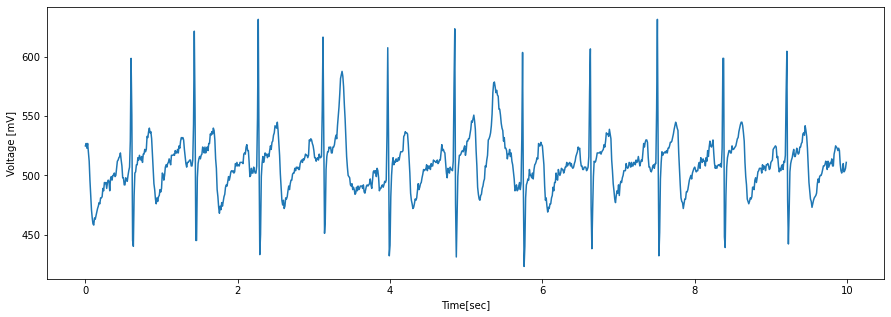

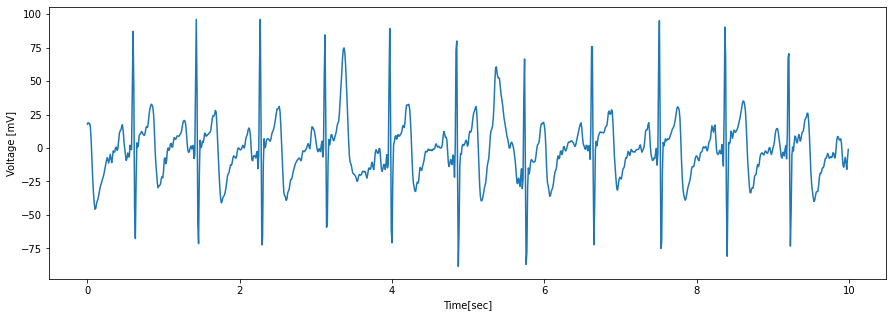

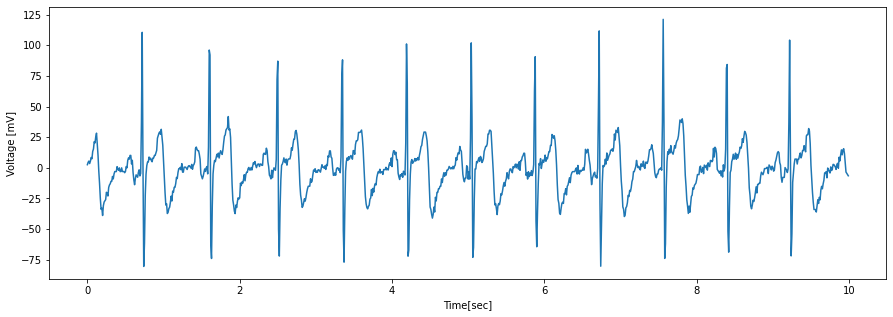

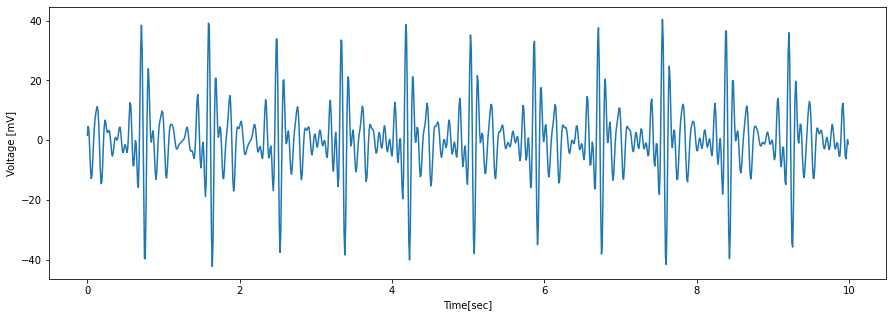

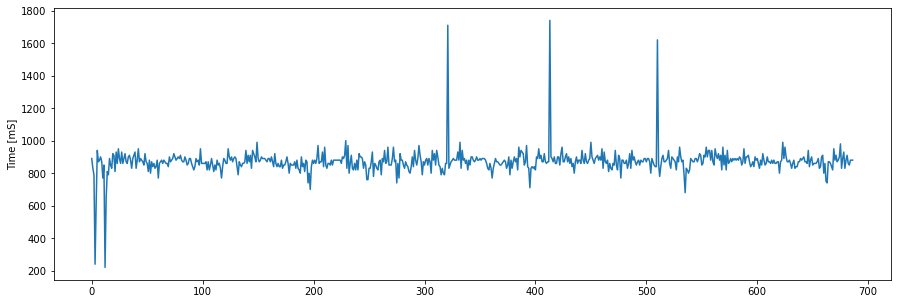

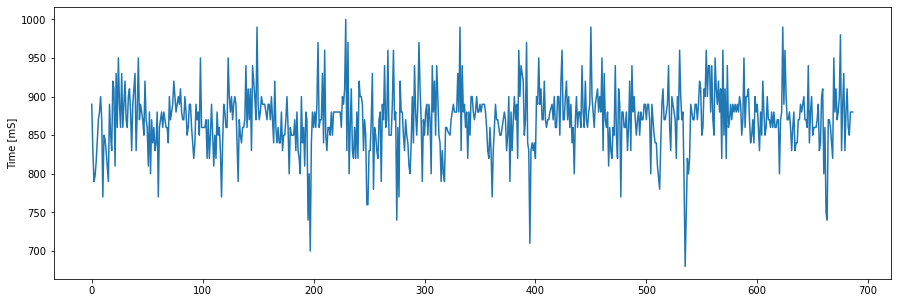

In [41]:
plt.figure(figsize=[15,5])

plt.plot(np.arange(0,10,0.01),ecg[24000:25000])
plt.xlabel('Time[sec]')
plt.ylabel('Voltage [mV]')

plt.figure(figsize=[15,5])
plt.plot(np.arange(0,10,0.01),ecg_filtered1[24000:25000])
plt.xlabel('Time[sec]')
plt.ylabel('Voltage [mV]')

plt.figure(figsize=[15,5])
plt.plot(np.arange(0,10,0.01),ecg_filtered[24000:25000])
plt.xlabel('Time[sec]')
plt.ylabel('Voltage [mV]' ) 
    
plt.figure(figsize=[15,5])
plt.plot(np.arange(0,10,0.01),ecg_filtered2[24000:25000])
plt.xlabel('Time[sec]')
plt.ylabel('Voltage [mV]' ) 

plt.figure(figsize=[15,5])

plt.plot(rr)
plt.ylabel('Time [mS]' ) 

plt.figure(figsize=[15,5])
plt.plot(rr_corrected)
plt.ylabel('Time [mS]' ) 


#### EDA

Text(0, 0.5, 'Amplitude in micro Siemens')

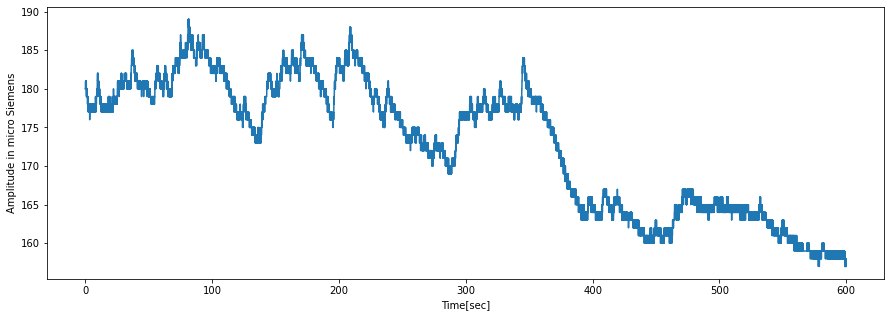

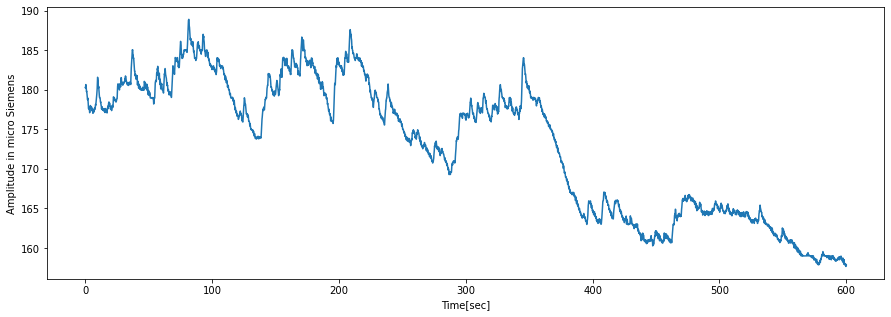

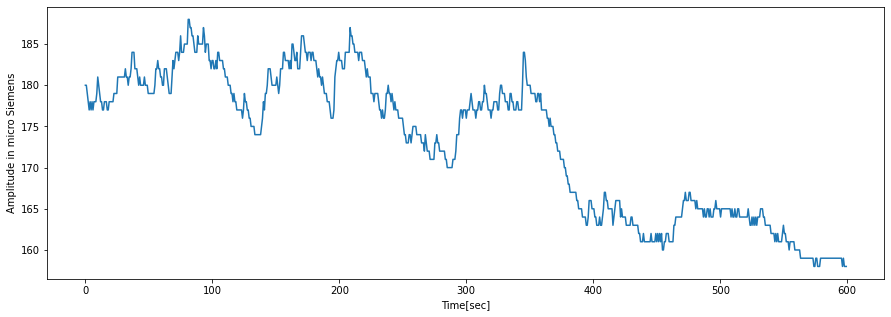

In [42]:
plt.figure(figsize=[15,5])
plt.plot(np.arange(0,600,0.01),eda[24000:84000])
plt.xlabel('Time[sec]')
plt.ylabel('Amplitude in micro Siemens')

plt.figure(figsize=[15,5])
plt.plot(np.arange(0,600,0.01),eda_filtered1[24000:84000])
plt.xlabel('Time[sec]')
plt.ylabel('Amplitude in micro Siemens')

plt.figure(figsize=[15,5])
plt.plot(np.arange(0,600,0.75),eda_new)
plt.xlabel('Time[sec]')
plt.ylabel('Amplitude in micro Siemens')



## ANI


In [43]:
ANI_mean= []
ANI_std= []
ANI_min= []
ANI_max= []
ANI_Entropy=[]

Energy_mean= []
Energy_std= []
Energy_min= []
Energy_max= []
Energy_Entropy=[]

for e in range(1,35):
    data_ANI = pd.read_csv("Datos/" + str(e) +'/ANI.csv',sep="\t")
    
    if 'ANI' in data_ANI.columns:
        ANI1 = list(data_ANI['ANI'][240:840])
    else:
        ANI1 = list(data_ANI['        HFVI'][240:840])    
    
    Energy = list(data_ANI['Energy'][240:840])
    
    ANI_mean.append(np.mean(ANI1))
    ANI_std.append(np.std(ANI1))
    ANI_min.append(min(ANI1))
    ANI_max.append(max(ANI1))
    res3=SampEn(ANI1,m = 2, r = 0.03)
    ANI_Entropy.append(res3)
    
    Energy_mean.append(np.mean(Energy))
    Energy_std.append(np.std(Energy))
    Energy_min.append(min(Energy))
    Energy_max.append(max(Energy))
    res4= SampEn(Energy,m = 2, r = 0.0003)
    Energy_Entropy.append(res4)
    


## EEG

In [44]:

fs = 178

Delta_R1=[]
Delta_L1=[]
Delta_R2=[]
Delta_L2=[]

Theta_R1=[]
Theta_L1=[]
Theta_R2=[]
Theta_L2=[]


Alpha_R1=[]
Alpha_L1=[]
Alpha_R2=[]
Alpha_L2=[]


Beta_R1=[]
Beta_L1=[]
Beta_R2=[]
Beta_L2=[]


Gamma_R1=[]
Gamma_L1=[]
Gamma_R2=[]
Gamma_L2=[]

f_low = 0.5       # Low cutoff frequency
f_high = 80        # High cutoff frequency
numtaps = 300       # Filter length

b_bp=signal.firwin(numtaps, [f_low, f_high], pass_zero=False,fs=178)     # Create FIR bandpass filter

# Apply filter (detrended signals)

f0 = 50     # Frequency to be removed from the signal (Hz)
Q = 30.0    # Quality factor

b_notch, a_notch = signal.iirnotch(f0, Q, fs)   # Create notch filter

for e in range(1,35): 
#     edf = mne.io.read_raw_edf("Datos/" + str(e) +'/EEG.edf')
#     header = ','.join(edf.ch_names)
#     np.savetxt("Datos/" + str(e) +'/EEG.csv', edf.get_data().T, delimiter=',', header=header)
    EEG= pd.read_csv("Datos/" + str(e) +'/EEG.csv',sep=",")
    ## Compute Welch's Periodogram for each segment
    hz=178
    L1= signal.detrend(list(EEG['# EEG L1(Fp1)'])[int(240*hz):int(840*hz)])
    R1= signal.detrend(list(EEG['EEG R1(Fp2)'])[240*hz:840*hz])
    L2= signal.detrend(list(EEG['EEG L2(F7)'])[240*hz:840*hz])
    R2= signal.detrend(list(EEG['EEG R2(F8)'])[240*hz:840*hz])
    
    
    L1 = signal.filtfilt(b_bp, 1, L1)
    R1 = signal.filtfilt(b_bp, 1, R1)   
    L2 = signal.filtfilt(b_bp, 1, L2)   
    R2 = signal.filtfilt(b_bp, 1, R2)   
    
    L1 = signal.filtfilt(b_notch, a_notch, L1)
    R1 = signal.filtfilt(b_notch, a_notch, R1)
    L2 = signal.filtfilt(b_notch, a_notch, L2)
    R2 = signal.filtfilt(b_notch, a_notch, R2)
    
    
    f_welch_eeg, Px_welch_eeg_L1 =signal.welch(L1,fs=fs, window='hamming', nperseg=128, nfft=1024)
    _, Px_welch_eeg_R1 =signal.welch(R1,fs=fs, window='hamming', nperseg=128, nfft=1024)
    _, Px_welch_eeg_L2 =signal.welch(L2,fs=fs, window='hamming', nperseg=128, nfft=1024)
    _, Px_welch_eeg_R2 =signal.welch(R2,fs=fs, window='hamming', nperseg=128, nfft=1024)
   
    print(e)

    ## Compute the total average power for each segment.
    width = np.diff(f_welch_eeg)
    pvec_total_1 = np.multiply(width,Px_welch_eeg_L1[0:-1])
    avgp_total_1 = np.sum(pvec_total_1);    # 1st segment

    pvec_total_2 = np.multiply(width,Px_welch_eeg_R1[0:-1])
    avgp_total_2 = np.sum(pvec_total_2);    # 2nd segment

    pvec_total_3 = np.multiply(width,Px_welch_eeg_L2[0:-1])
    avgp_total_3 = np.sum(pvec_total_3);    # 3rd segment
    
    pvec_total_4 = np.multiply(width,Px_welch_eeg_R2[0:-1])
    avgp_total_4 = np.sum(pvec_total_4);    # 4rd segment
    

    ## Compute the average power on the delta band for each segment.
    
    f_low_index = (np.abs(f_welch_eeg-0)).argmin()    # Compute the index that corresponds (or is close) to f=0 Hz
    f_high_index = (np.abs(f_welch_eeg-4)).argmin()  # Compute the index that corresponds (or is close) to f=4 Hz



    pvec_1 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L1[f_low_index:f_high_index])
    avgp_1 = np.sum(pvec_1);     # Average power on the Delta band for the 1st segment.
    r_seg1 = avgp_1/avgp_total_1;   # Delta-band power vs total average power ratio for the 1st segment.

    pvec_2 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R1[f_low_index:f_high_index])
    avgp_2 = np.sum(pvec_2);     # Average power on the Delta band for the 2nd segment.
    r_seg2 = avgp_2/avgp_total_2;   # Delta-band power vs total average power ratio for the 2nd segment.

    pvec_3 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L2[f_low_index:f_high_index])
    avgp_3 = np.sum(pvec_3);     # Average power on the Delta band for the 3rd segment.
    r_seg3 = avgp_3/avgp_total_3;   # Delta-band power vs total average power ratio for the 3rd segment.
    
    pvec_4 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R2[f_low_index:f_high_index])
    avgp_4 = np.sum(pvec_4);     # Average power on the Delta band for the 3rd segment.
    r_seg4 = avgp_4/avgp_total_4;   # Delta-band power vs total average power ratio for the 3rd segment.
    
    Delta_R1.append(r_seg1)
    Delta_L1.append(r_seg2)
    Delta_R2.append(r_seg3)
    Delta_L2.append(r_seg4)
    
    print('Delta band power ratio (L1): ', r_seg1)
    print('Delta band power ratio (R1): ', r_seg2)
    print('Delta band power ratio (L2): ', r_seg3)
    print('Delta band power ratio (R2): ', r_seg4)
    
    

    
    
    ## Compute the average power on the Theta band for each segment.
    
    f_low_index = (np.abs(f_welch_eeg-4)).argmin()    # Compute the index that corresponds (or is close) to f=4 Hz
    f_high_index = (np.abs(f_welch_eeg-8)).argmin()  # Compute the index that corresponds (or is close) to f=8 Hz


    pvec_1 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L1[f_low_index:f_high_index])
    avgp_1 = np.sum(pvec_1);     # Average power on the Theta band for the 1st segment.
    r_seg1 = avgp_1/avgp_total_1;   # Theta-band power vs total average power ratio for the 1st segment.

    pvec_2 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R1[f_low_index:f_high_index])
    avgp_2 = np.sum(pvec_2);     # Average power on the Thetaband for the 2nd segment.
    r_seg2 = avgp_2/avgp_total_2;   # Theta-band power vs total average power ratio for the 2nd segment.

    pvec_3 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L2[f_low_index:f_high_index])
    avgp_3 = np.sum(pvec_3);     # Average power on the Theta band for the 3rd segment.
    r_seg3 = avgp_3/avgp_total_3;   # Theta-band power vs total average power ratio for the 3rd segment.
    
    pvec_4 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R2[f_low_index:f_high_index])
    avgp_4 = np.sum(pvec_4);     # Average power on the Theta band for the 3rd segment.
    r_seg4 = avgp_4/avgp_total_4;   # Theta-band power vs total average power ratio for the 3rd segment.
    
    
    Theta_R1.append(r_seg1)
    Theta_L1.append(r_seg2)
    Theta_R2.append(r_seg3)
    Theta_L2.append(r_seg4)
    
    
    print('Theta band power ratio (L1): ', r_seg1)
    print('Theta band power ratio (R1): ', r_seg2)
    print('Theta band power ratio (L2): ', r_seg3)
    print('Theta band power ratio (R2): ', r_seg4)
    
    
    
    ## Compute the average power on the alpha band for each segment.
    
    f_low_index = (np.abs(f_welch_eeg-8)).argmin()    # Compute the index that corresponds (or is close) to f=8 Hz
    f_high_index = (np.abs(f_welch_eeg-12)).argmin()  # Compute the index that corresponds (or is close) to f=13 Hz

    pvec_1 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L1[f_low_index:f_high_index])
    avgp_1 = np.sum(pvec_1);     # Average power on the alpha band for the 1st segment.
    r_seg1 = avgp_1/avgp_total_1;   # Alpha-band power vs total average power ratio for the 1st segment.

    pvec_2 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R1[f_low_index:f_high_index])
    avgp_2 = np.sum(pvec_2);     # Average power on the alpha band for the 2nd segment.
    r_seg2 = avgp_2/avgp_total_2;   # Alpha-band power vs total average power ratio for the 2nd segment.

    pvec_3 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L2[f_low_index:f_high_index])
    avgp_3 = np.sum(pvec_3);     # Average power on the alpha band for the 3rd segment.
    r_seg3 = avgp_3/avgp_total_3;   # Alpha-band power vs total average power ratio for the 3rd segment.
    
    pvec_4 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R2[f_low_index:f_high_index])
    avgp_4 = np.sum(pvec_4);     # Average power on the alpha band for the 3rd segment.
    r_seg4 = avgp_4/avgp_total_4;   # Alpha-band power vs total average power ratio for the 3rd segment.
     
    
    Alpha_R1.append(r_seg1)
    Alpha_L1.append(r_seg2)
    Alpha_R2.append(r_seg3)
    Alpha_L2.append(r_seg4)
    
    
    print('Alpha band power ratio (L1): ', r_seg1)
    print('Alpha band power ratio (R1): ', r_seg2)
    print('Alpha band power ratio (L2): ', r_seg3)
    print('Alpha band power ratio (R2): ', r_seg4)
    
    #Compute the average power of the Beta band
    
    f_low_index = (np.abs(f_welch_eeg-13)).argmin()    # Compute the index that corresponds (or is close) to f=13 Hz
    f_high_index = (np.abs(f_welch_eeg-30)).argmin()  # Compute the index that corresponds (or is close) to f=30 Hz


    pvec_1 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L1[f_low_index:f_high_index])
    avgp_1 = np.sum(pvec_1);     # Average power on the beta band for the 1st segment.
    r_seg1 = avgp_1/avgp_total_1;   # beta-band power vs total average power ratio for the 1st segment.

    pvec_2 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R1[f_low_index:f_high_index])
    avgp_2 = np.sum(pvec_2);     # Average power on the beta band for the 2nd segment.
    r_seg2 = avgp_2/avgp_total_2;   # beta-band power vs total average power ratio for the 2nd segment.

    pvec_3 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L2[f_low_index:f_high_index])
    avgp_3 = np.sum(pvec_3);     # Average power on the beta band for the 3rd segment.
    r_seg3 = avgp_3/avgp_total_3;   # beta-band power vs total average power ratio for the 3rd segment.
    
    pvec_4 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R2[f_low_index:f_high_index])
    avgp_4 = np.sum(pvec_4);     # Average power on the beta band for the 3rd segment.
    r_seg4 = avgp_4/avgp_total_4;   # beta -band power vs total average power ratio for the 3rd segment.
    

    
    Beta_R1.append(r_seg1)
    Beta_L1.append(r_seg2)
    Beta_R2.append(r_seg3)
    Beta_L2.append(r_seg4)
    
    
    
    print('Beta band power ratio (L1): ', r_seg1)
    print('Beta band power ratio (R1): ', r_seg2)
    print('Beta band power ratio (L2): ', r_seg3)
    print('Beta band power ratio (R2): ', r_seg4)
    
    
    
    #Compute the average power of the Gamma band
    
    f_low_index = (np.abs(f_welch_eeg-30)).argmin()    # Compute the index that corresponds (or is close) to f=30 Hz
    f_high_index = (np.abs(f_welch_eeg-80)).argmin()  # Compute the index that corresponds (or is close) to f=80 Hz


    pvec_1 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L1[f_low_index:f_high_index])
    avgp_1 = np.sum(pvec_1);     # Average power on the Gamma band for the 1st segment.
    r_seg1 = avgp_1/avgp_total_1;   # Gamma-band power vs total average power ratio for the 1st segment.

    pvec_2 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R1[f_low_index:f_high_index])
    avgp_2 = np.sum(pvec_2);     # Average power on the Gamma band for the 2nd segment.
    r_seg2 = avgp_2/avgp_total_2;   # Gamma-band power vs total average power ratio for the 2nd segment.

    pvec_3 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_L2[f_low_index:f_high_index])
    avgp_3 = np.sum(pvec_3);     # Average power on the Gamma band for the 3rd segment.
    r_seg3 = avgp_3/avgp_total_3;   # Gamma-band power vs total average power ratio for the 3rd segment.
    
    pvec_4 = np.multiply(width[f_low_index:f_high_index],Px_welch_eeg_R2[f_low_index:f_high_index])
    avgp_4 = np.sum(pvec_4);     # Average power on the Gamma band for the 3rd segment.
    r_seg4 = avgp_4/avgp_total_4;   # Gamma -band power vs total average power ratio for the 3rd segment.
    

    
    Gamma_R1.append(r_seg1)
    Gamma_L1.append(r_seg2)
    Gamma_R2.append(r_seg3)
    Gamma_L2.append(r_seg4)
    
    
    
    print('Gamma band power ratio (L1): ', r_seg1)
    print('Gamma band power ratio (R1): ', r_seg2)
    print('Gamma band power ratio (L2): ', r_seg3)
    print('Gamma band power ratio (R2): ', r_seg4)

1
Delta band power ratio (L1):  0.31124124573978323
Delta band power ratio (R1):  0.33653637858025465
Delta band power ratio (L2):  0.3568776072708224
Delta band power ratio (R2):  0.30946336709998207
Theta band power ratio (L1):  0.14344388023475682
Theta band power ratio (R1):  0.1199041303197507
Theta band power ratio (L2):  0.18722670234984612
Theta band power ratio (R2):  0.15314362224611489
Alpha band power ratio (L1):  0.11843143542118947
Alpha band power ratio (R1):  0.12076129798628715
Alpha band power ratio (L2):  0.155061602907882
Alpha band power ratio (R2):  0.17390660732185914
Beta band power ratio (L1):  0.29634028020902065
Beta band power ratio (R1):  0.2934209791216876
Beta band power ratio (L2):  0.1990831720628723
Beta band power ratio (R2):  0.2199106666846195
Gamma band power ratio (L1):  0.1048736582513509
Gamma band power ratio (R1):  0.1046322326761618
Gamma band power ratio (L2):  0.07642793156197888
Gamma band power ratio (R2):  0.11404593521356822
2
Delta ban

#### Plot

In [45]:
EEG= pd.read_csv("Datos/" + str(19) +'/EEG.csv',sep=",") 
f_low = 0.5        # Low cutoff frequency
f_high = 80        # High cutoff frequency
numtaps = 300      # Filter length
fs=178
b_bp=signal.firwin(numtaps, [f_low, f_high], pass_zero=False,fs=178)     # Create FIR bandpass filter
hz=178
L1= signal.detrend(list(EEG['# EEG L1(Fp1)'])[int(240*hz):int(840*hz)])
R1= signal.detrend(list(EEG['EEG R1(Fp2)'])[240*hz:840*hz])
L2= signal.detrend(list(EEG['EEG L2(F7)'])[240*hz:840*hz])
R2= signal.detrend(list(EEG['EEG R2(F8)'])[240*hz:840*hz])

f_welch_eeg, Px_welch_eeg_L1 =signal.welch(L1,fs=fs, window='hamming', nperseg=128, nfft=1024)

L1_ = signal.filtfilt(b_bp, 1, L1)
R1_ = signal.filtfilt(b_bp, 1, R1)   
L2_ = signal.filtfilt(b_bp, 1, L2)   
R2_ = signal.filtfilt(b_bp, 1, R2) 

f_welch_eeg1, Px_welch_eeg_L1_ =signal.welch(L1_,fs=fs, window='hamming', nperseg=128, nfft=1024)
f0 = 50     # Frequency to be removed from the signal (Hz)
Q = 30.0    # Quality factor

b_notch, a_notch = signal.iirnotch(f0, Q, fs) 

L1º = signal.filtfilt(b_notch, a_notch, L1_)
R1º = signal.filtfilt(b_notch, a_notch, R1_)
L2º = signal.filtfilt(b_notch, a_notch, L2_)
R2º = signal.filtfilt(b_notch, a_notch, R2_)

f_welch_eeg2, Px_welch_eeg_L1º =signal.welch(L1º,fs=fs, window='hamming', nperseg=128, nfft=1024)
    

Text(0.5, 0, 'Frequency [HZ]')

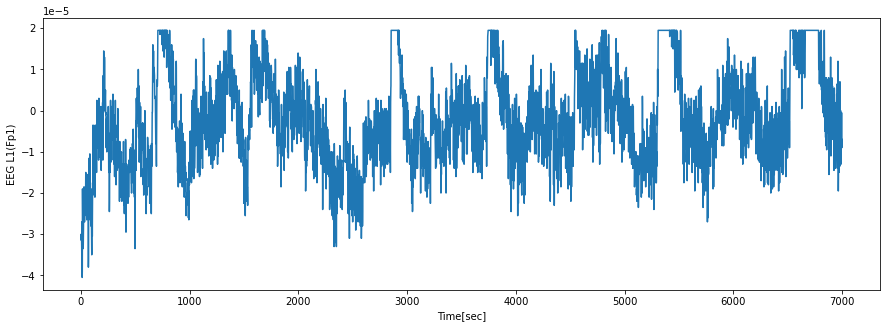

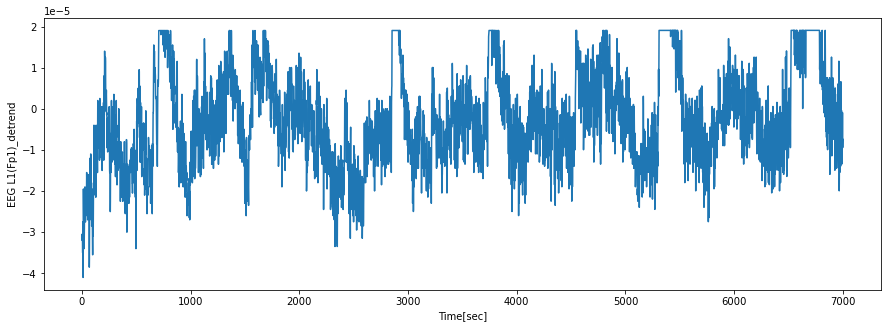

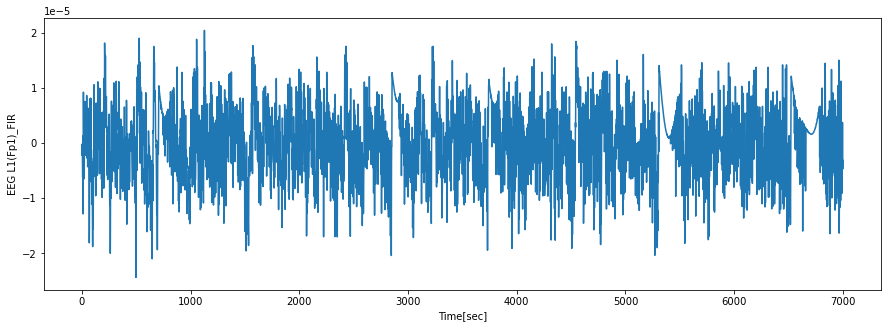

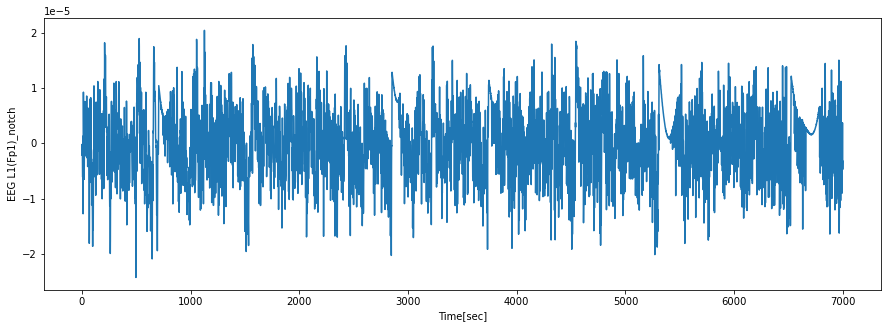

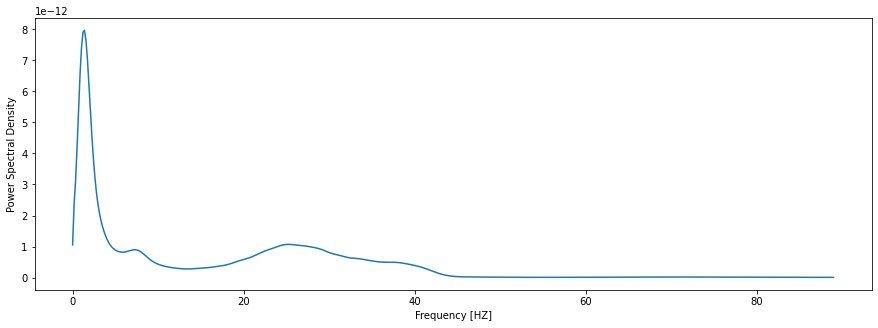

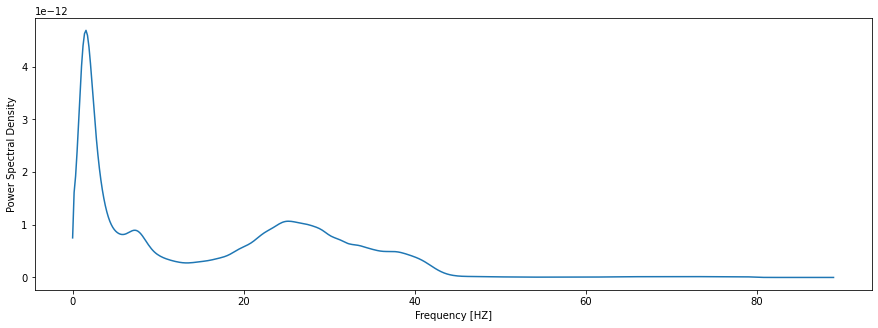

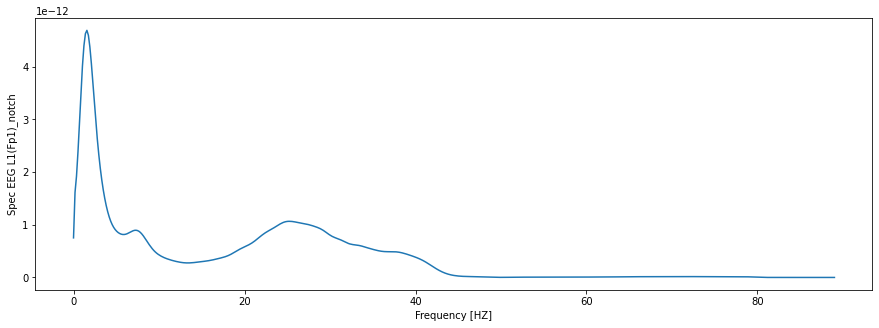

In [46]:
plt.figure(figsize=[15,5])
plt.plot(list(EEG['# EEG L1(Fp1)'])[int(240*hz):int(840*hz)][20000:27000])
plt.xlabel('Time[sec]')
plt.ylabel('EEG L1(Fp1)')

plt.figure(figsize=[15,5])
plt.plot(L1[20000:27000])
plt.xlabel('Time[sec]')
plt.ylabel('EEG L1(Fp1)_detrend')

plt.figure(figsize=[15,5])
plt.plot(L1_[20000:27000])
plt.xlabel('Time[sec]')
plt.ylabel('EEG L1(Fp1)_FIR')

plt.figure(figsize=[15,5])
plt.plot(L1º[20000:27000])
plt.xlabel('Time[sec]')
plt.ylabel('EEG L1(Fp1)_notch')



plt.figure(figsize=[15,5])
plt.plot(f_welch_eeg,Px_welch_eeg_L1)

plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency [HZ]')                         


plt.figure(figsize=[15,5])
plt.plot(f_welch_eeg1,Px_welch_eeg_L1_)

plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency [HZ]')
                           


plt.figure(figsize=[15,5])
plt.plot(f_welch_eeg2,Px_welch_eeg_L1º)

plt.ylabel('Spec EEG L1(Fp1)_notch')

plt.xlabel('Frequency [HZ]')

In [47]:
print(len(Eda_mean))

34


## Table

In [48]:
Base= pd.read_excel('Datos/Database.xlsx',index_col=0)

Base['ANI_mean']=ANI_mean
Base['ANI_std']=ANI_std
Base['ANI_min']=ANI_min
Base['ANI_max']=ANI_max
Base['ANI_Entropy']=ANI_Entropy

Base['Energy_mean']=Energy_mean
Base['Energy_std']=Energy_std
Base['Energy_min']=Energy_min
Base['Energy_max']=Energy_max
Base['Energy_Entropy']=Energy_Entropy




Base['Eda_mean']=Eda_mean
Base['Eda_std']=Eda_std
Base['Eda_min']=Eda_min
Base['Eda_max']=Eda_max
Base['Eda_Entropy']=Eda_Entropy


Base["average"]=average_value
Base["nn50"]=nn50_value
Base["rmssd"]=rmssd_value


Base["hrvTriangIndex"]=hrvTriangIndex_value
Base["logIndex"]=logIndex_value
Base["tinn"]= tinn_value


Base["Ptot"]=Ptot_value
Base["Pulf"]=Pulf_value
Base["Pvlf"]=Pvlf_value
Base["Plf"]=Plf_value
Base["Phf"]=Phf_value
Base["lfhf_ratio"]=lfhf_ratio_value


Base['NN_Entropy']=rr_Entropy

Base["Delta_R1"]=Delta_R1
Base["Delta_L1"]=Delta_L1
Base["Delta_R2"]=Delta_R2
Base["Delta_L2"]=Delta_L2

Base["Theta_R1"]=Theta_R1
Base["Theta_L1"]=Theta_L1
Base["Theta_R2"]=Theta_R2
Base["Theta_L2"]=Theta_L2


Base["Alpha_R1"]=Alpha_R1
Base["Alpha_L1"]=Alpha_L1
Base["Alpha_R2"]=Alpha_R2
Base["Alpha_L2"]=Alpha_L2


Base["Beta_R1"]=Beta_R1
Base["Beta_L1"]=Beta_L1
Base["Beta_R2"]=Beta_R2
Base["Beta_L2"]=Beta_L2


Base["Gamma_R1"]=Gamma_R1
Base["Gamma_L1"]=Gamma_L1
Base["Gamma_R2"]=Gamma_R2
Base["Gamma_L2"]=Gamma_L2

In [49]:
Base = Base.drop(['Name'],axis=1)
Base.to_excel('Complete_database.xlsx')